In [1]:
# config
from dataclasses import dataclass

@dataclass
class RNAConfig:
    """Global configuration for the RNAcompete Data Pipeline."""
    
    # Data Path
    DATA_PATH: str = "norm_data.txt" #NOTE: Only change this if you want to use a different path
    
    # Metadata is an Excel file
    METADATA_PATH: str = "metadata.xlsx" #NOTE: Only change this if you want to use a different path
    METADATA_SHEET: str = "Master List--Plasmid Info"
    
    # Save Path
    SAVE_DIR: str = "data" #NOTE: Only change this if you want to use a different path
    
    # Sequence Parameters
    SEQ_MAX_LEN: int = 41
    ALPHABET: str = "ACGUN"
    
    # Preprocessing
    CLIP_PERCENTILE: float = 99.95
    EPSILON: float = 1e-6  # For numerical stability
    
    # Split Identifiers
    TRAIN_SPLIT_ID: str = "SetA"
    TEST_SPLIT_ID: str = "SetB"
    
    VAL_SPLIT_PCT: float = 0.2
    SEED: int = 42 # NOTE: Change this only if you want to test reproducibility

In [2]:
## Utils
import os
import random
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from typing import List, Tuple


def configure_seed(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


class RNACompeteLoader:
    def __init__(self, config: RNAConfig):
        """
        Initializes the loader.
        """
        self.cfg = config
        self.meta_df = None
        self.data_df = None
        self.protein_to_id = None

        # Setup Encoding
        self.char_map = {
            'A': np.array([1, 0, 0, 0], dtype=np.float32),
            'C': np.array([0, 1, 0, 0], dtype=np.float32),
            'G': np.array([0, 0, 1, 0], dtype=np.float32),
            'U': np.array([0, 0, 0, 1], dtype=np.float32),
            'N': np.array([0.25, 0.25, 0.25, 0.25], dtype=np.float32)
        }
        self.padding_vec = np.zeros(4, dtype=np.float32)

    def _ensure_data_loaded(self):
        """Helper to load the heavy files only when necessary."""
        if self.data_df is not None:
            return
        
        # Load Metadata
        print(f"Loading Metadata from {self.cfg.METADATA_PATH}...")
        start_time = time.time()
        try:
            if self.cfg.METADATA_PATH.endswith('.xlsx'):
                # Requires 'openpyxl' installed!
                self.meta_df = pd.read_excel(
                    self.cfg.METADATA_PATH, 
                    sheet_name=self.cfg.METADATA_SHEET
                )
            else:
                self.meta_df = pd.read_csv(self.cfg.METADATA_PATH)
        except Exception as e:
            print(f"Error loading metadata: {e}")
            raise e
        print(f"  > Metadata loaded in {time.time() - start_time:.2f} seconds.")

        # Clean column names (strip whitespace)
        self.meta_df.columns = [c.strip() for c in self.meta_df.columns]
        
        # Create Protein Name -> RNCMPT ID mapping
        self.protein_to_id = pd.Series(
            self.meta_df['Motif_ID'].values, 
            index=self.meta_df['Protein_name']
        ).to_dict()
        
        # Load Data 
        print(f"Loading Data from {self.cfg.DATA_PATH}...")
        start_time = time.time()

        # standard RNAcompete is tab-separated
        self.data_df = pd.read_csv(self.cfg.DATA_PATH, sep='\t', low_memory=False)    
        print(f"  > Data Matrix loaded in {time.time() - start_time:.2f} seconds.")

        # Clean data columns
        self.data_df.columns = [c.strip() for c in self.data_df.columns]

    def list_proteins(self) -> List[str]:
        """Returns a sorted list of available protein names."""
        self._ensure_data_loaded()
        valid_proteins = []
        matrix_cols = set(self.data_df.columns)
        
        for name, pid in self.protein_to_id.items():
            if pid in matrix_cols:
                valid_proteins.append(name)
        
        return sorted(valid_proteins)

    def _encode_sequence(self, seq: str) -> Tuple[np.ndarray, np.ndarray]:
        """One-hot encodes a single RNA sequence."""
        # Handle NaN or non-string sequence entries gracefully
        if not isinstance(seq, str):
            seq = "N" * self.cfg.SEQ_MAX_LEN
        
        seq = seq.upper()[:self.cfg.SEQ_MAX_LEN]
        
        encoded = np.zeros((self.cfg.SEQ_MAX_LEN, len(self.padding_vec)), dtype=np.float32)
        mask = np.zeros(self.cfg.SEQ_MAX_LEN, dtype=np.float32)
        
        for i, base in enumerate(seq):
            encoded[i] = self.char_map.get(base, self.char_map['N'])
            mask[i] = 1.0
        
        return encoded, mask
    
    def _preprocess_intensities(self, intensities: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Applies: Mask NaNs -> Clip -> Log -> Z-score."""
        mask = (~np.isnan(intensities)).astype(np.float32)
        clean_vals = np.nan_to_num(intensities, nan=0.0)
        
        # Clip
        if np.sum(mask) > 0:
            valid_data = intensities[mask == 1]
            clip_val = np.percentile(valid_data, self.cfg.CLIP_PERCENTILE)
            clean_vals = np.clip(clean_vals, None, clip_val)

        # Log Transform (Shift to positive)
        min_val = np.min(clean_vals)
        shift = 0
        if min_val <= 0:
            shift = abs(min_val) + 1.0
        clean_vals = np.log(clean_vals + shift + self.cfg.EPSILON)
        
        # Z-Score
        masked_vals = clean_vals[mask == 1]
        if len(masked_vals) > 0:
            mean = np.mean(masked_vals)
            std = np.std(masked_vals) + self.cfg.EPSILON
            clean_vals = (clean_vals - mean) / std
        
        clean_vals = clean_vals * mask
        return clean_vals, mask
    
    def get_data(self, protein_name: str, split: str = 'train') -> TensorDataset:
        """
        Main method to get PyTorch Dataset for a specific protein.
        """
        # Fast path: use preprocessed tensors if they are already available (e.g., Kaggle input dir)
        kaggle_path = f"/kaggle/input/rnacompete-dt/{protein_name}_{split}_data.pt"
        if os.path.exists(kaggle_path):
            print(f"Found preprocessed data at {kaggle_path}. Loading...")
            tensors = torch.load(kaggle_path, weights_only=False)
            return TensorDataset(*tensors)

        # Check cache first
        os.makedirs(self.cfg.SAVE_DIR, exist_ok=True)
        data_path = os.path.join(self.cfg.SAVE_DIR, f"{protein_name}_{split}_data.pt")

        if os.path.exists(data_path):
            print(f"Found cached data for {protein_name} ({split}). Loading from {data_path}...")
            try:
                tensors = torch.load(data_path, weights_only=False)
                return TensorDataset(*tensors)
            except Exception as e:
                print(f"Cache seems corrupted: {e}. Will reload from scratch.")

        self._ensure_data_loaded()

        if protein_name not in self.protein_to_id:
            raise ValueError(f"Protein '{protein_name}' not found in metadata.")
        
        rncmpt_id = self.protein_to_id[protein_name]
        
        if rncmpt_id not in self.data_df.columns:
            raise ValueError(f"ID {rncmpt_id} for {protein_name} missing from data matrix.")

        s_lower = split.lower()

        if s_lower == 'test':
            # Test set is just SetB, nice and simple
            subset = self.data_df[self.data_df['Probe_Set'] == self.cfg.TEST_SPLIT_ID].copy()

        elif s_lower in ['train', 'val']:
            # For train/val, we need to split SetA. 
            # We use a fixed seed to ensure grading consistency (everyone gets the same split).
            full_set = self.data_df[self.data_df['Probe_Set'] == self.cfg.TRAIN_SPLIT_ID]
            
            # Explicitly sort by index to ensure deterministic order before shuffling
            full_set = full_set.sort_index()
            
            n_samples = len(full_set)
            indices = np.arange(n_samples)
            
            # Local RandomState prevents messing with global seeds
            rng = np.random.RandomState(self.cfg.SEED)
            rng.shuffle(indices)
            
            val_size = int(n_samples * self.cfg.VAL_SPLIT_PCT)
            
            if s_lower == 'val':
                # Validation gets the first chunk
                subset_indices = indices[:val_size]
            else:
                # Train gets the leftovers
                subset_indices = indices[val_size:]
                
            subset = full_set.iloc[subset_indices].copy()
        else:
            raise ValueError(f"Unknown split '{split}'. Please use 'train', 'val', or 'test'.")
        
        # Extract Sequences
        raw_seqs = subset['RNA_Seq'].values
        encoded_list = []
        mask_list = []

        for s in raw_seqs:
            encoded, seq_mask = self._encode_sequence(s) 
            encoded_list.append(encoded)
            mask_list.append(seq_mask)

        X = np.stack(encoded_list)          # shape: (B, SEQ_MAX_LEN, 4)
        sequence_masks = np.stack(mask_list)  # shape: (B, SEQ_MAX_LEN)

        # Process Intensities
        # Force conversion to numeric (floats), turning any strings/errors into NaN
        raw_intensities = pd.to_numeric(subset[rncmpt_id], errors='coerce').values
        Y, mask = self._preprocess_intensities(raw_intensities)
        
        # Convert to Tensor
        dataset = TensorDataset(
            torch.FloatTensor(X),                     # (B, 41, 4)
            torch.FloatTensor(sequence_masks),        # (B, 41)
            torch.FloatTensor(Y).unsqueeze(1),        # (B, 1)
            torch.FloatTensor(mask).unsqueeze(1)      # (B, 1)
        )
        
        # Save for next time
        print(f"Saving processed data to {data_path}...")
        torch.save(dataset.tensors, data_path)
        
        return dataset
    

def load_rnacompete_data(protein_name: str, split: str = 'train', config: RNAConfig = None):
    """
    Convenience function to load data for a single protein without manually managing the loader class.
    Note: Instantiates the loader from scratch (loads files). 
    For bulk processing, use RNACompeteLoader class directly.
    """
    if config is None:
        config = RNAConfig()

    loader = RNACompeteLoader(config)
    return loader.get_data(protein_name, split)


def masked_spearman_correlation(preds, targets, masks):
    """
    Calculates Spearman Rank Correlation on masked data.
    Expects:
        preds: (B, 1)
        targets: (B, 1)
        masks: (B, 1)
    Outputs:
        correlation: scalar
    """
    # Flatten and detach (metrics don't need gradients)
    preds = preds.squeeze().detach()
    targets = targets.squeeze().detach()
    masks = masks.squeeze().bool()
    
    valid_preds = preds[masks]
    valid_targets = targets[masks]
    
    if valid_preds.numel() < 2:
        return torch.tensor(0.0)

    # argsort twice gets us the ranks
    pred_ranks = valid_preds.argsort().argsort().float()
    target_ranks = valid_targets.argsort().argsort().float()

    # Pearson on ranks == Spearman
    pred_mean = pred_ranks.mean()
    target_mean = target_ranks.mean()

    pred_var = pred_ranks - pred_mean
    target_var = target_ranks - target_mean

    correlation = (pred_var * target_var).sum() / torch.sqrt((pred_var ** 2).sum() * (target_var ** 2).sum())

    return correlation


def masked_mse_loss(preds, targets, masks):
    """
    Calculates Mean Squared Error, ignoring padded elements.
    Expects:
        preds: (B, 1)
        targets: (B, 1)
        masks: (B, 1)
    Outputs:
        loss: scalar
    """
    # Flatten to 1D
    preds = preds.squeeze()
    targets = targets.squeeze()
    masks = masks.squeeze().bool()

    # Filter out padded values
    masked_preds = preds[masks]
    masked_targets = targets[masks]
    
    # Handle empty batch case
    if masked_preds.numel() == 0:
        return torch.tensor(0.0, device=preds.device, requires_grad=True)

    # MSE on valid data
    squared_error = (masked_preds - masked_targets) ** 2
    loss = torch.mean(squared_error)
    
    return loss


def plot(epochs, plottables, filename=None, ylim=None):
    """Plot the plottables over the epochs.
    
    Plottables is a dictionary mapping labels to lists of values.
    """
    plt.clf()
    plt.xlabel('Epoch')
    for label, plottable in plottables.items():
        plt.plot(epochs, plottable, label=label)
    plt.legend()
    if ylim:
        plt.ylim(ylim)
    if filename:
        plt.savefig(filename, bbox_inches='tight')


# ---------------------------------------------------------------------------
# Data exploration helpers
# ---------------------------------------------------------------------------

def dataset_summary(dataset: TensorDataset) -> dict:
    """Return simple stats about a TensorDataset (X, y, mask)."""
    X, y, mask = dataset.tensors
    mask_bool = mask.squeeze().bool()

    # Masked targets only
    valid_targets = y.squeeze()[mask_bool]
    valid_np = valid_targets.detach().cpu().numpy() if valid_targets.numel() else np.array([])

    # Sequence lengths (after padding removal)
    seq_lengths = (X.sum(dim=2) > 0).sum(dim=1).detach().cpu().numpy()

    return {
        "num_samples": int(X.shape[0]),
        "seq_min_len": int(seq_lengths.min()) if len(seq_lengths) else 0,
        "seq_max_len": int(seq_lengths.max()) if len(seq_lengths) else 0,
        "seq_mean_len": float(seq_lengths.mean()) if len(seq_lengths) else 0.0,
        "mask_fraction": float(mask_bool.float().mean().item()),
        "target_min": float(valid_np.min()) if valid_np.size else 0.0,
        "target_max": float(valid_np.max()) if valid_np.size else 0.0,
        "target_mean": float(valid_np.mean()) if valid_np.size else 0.0,
        "target_std": float(valid_np.std()) if valid_np.size else 0.0,
    }



Using device: cuda

Using default configuration:
  num_filters: 64
  kernel_size: 8
  lstm_hidden: 64
  lstm_layers: 1
  dropout_rate: 0.3
  num_attention_heads: 1
  learning_rate: 0.001

TRAINING FINAL MODEL FOR RBFOX1

Loading data (this will take a minute or two)...
Found preprocessed data at /kaggle/input/rnacompete-dt/RBFOX1_train_data.pt. Loading...
Found preprocessed data at /kaggle/input/rnacompete-dt/RBFOX1_val_data.pt. Loading...
Found preprocessed data at /kaggle/input/rnacompete-dt/RBFOX1_test_data.pt. Loading...
Train set: 96261 samples
Val set:   24065 samples
Test set:  121031 samples

Model Architecture:
RNABindingCNNBiLSTM(
  (conv1): Conv1d(4, 64, kernel_size=(8,), stride=(1,), padding=(4,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_conv): Dropout(p=0.15, inplace=False)
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (attention_pool): AttentionPooling(
    (query_proj): Linear(in_features=128, ou

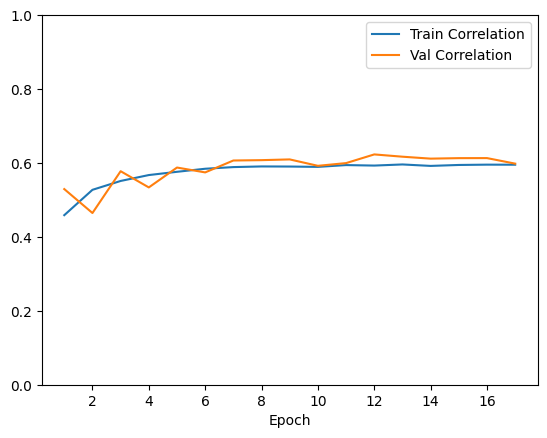

In [8]:
# RNN_attention
"""
CNN + BiLSTM model for RNAcompete binding prediction.

Motifs are detected by a convolutional layer, and a bidirectional LSTM
models upstream/downstream context before fully connected layers map
features to binding affinity.
"""

import argparse
import json
import os
import time
from typing import Dict, List, Tuple, Optional
from argparse import Namespace

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader


# ============================================================================
# Attention Pooling Module
# ============================================================================


class AttentionPooling(nn.Module):
	"""
	Scaled Dot-Product Attention Pooling Layer.
	
	Computes attention weights across all sequence positions and produces
	a weighted aggregation (pooling) into a single representation. This allows
	the model to learn which positions are most informative for prediction.
	
	Args:
		hidden_dim: Dimension of input features (e.g., 2*lstm_hidden for BiLSTM)
		num_heads: Number of attention heads for multi-head attention
	"""

	def __init__(self, hidden_dim: int, num_heads: int = 2):
		super().__init__()

		self.hidden_dim = hidden_dim
		self.num_heads = num_heads
		self.head_dim = hidden_dim // num_heads

		# Ensure hidden_dim is divisible by num_heads
		if hidden_dim % num_heads != 0:
			raise ValueError(f"hidden_dim ({hidden_dim}) must be divisible by num_heads ({num_heads})")

		# Linear projections for Query, Key, Value
		self.query_proj = nn.Linear(hidden_dim, hidden_dim)
		self.key_proj = nn.Linear(hidden_dim, hidden_dim)
		self.value_proj = nn.Linear(hidden_dim, hidden_dim)
		
		# Output projection
		self.output_proj = nn.Linear(hidden_dim, hidden_dim)
		
		# Scaling factor for numerical stability
		self.scale = (self.head_dim) ** -0.5

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		"""
		Apply attention-based pooling to sequence.
		
		Args:
			x: Input tensor of shape (batch_size, seq_len, hidden_dim)
		
		Returns:
			Pooled representation of shape (batch_size, hidden_dim)
		"""
		batch_size = x.size(0)
		seq_len = x.size(1)

		# Project to Q, K, V: (batch, seq_len, hidden_dim)
		Q = self.query_proj(x)
		K = self.key_proj(x)
		V = self.value_proj(x)

		# Reshape for multi-head attention
		# (batch, seq_len, hidden_dim) -> (batch, seq_len, num_heads, head_dim)
		Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim)
		K = K.view(batch_size, seq_len, self.num_heads, self.head_dim)
		V = V.view(batch_size, seq_len, self.num_heads, self.head_dim)

		# Transpose for attention computation
		# (batch, seq_len, num_heads, head_dim) -> (batch, num_heads, seq_len, head_dim)
		Q = Q.transpose(1, 2)
		K = K.transpose(1, 2)
		V = V.transpose(1, 2)

		# Compute attention scores: Q @ K^T / sqrt(d_k)
		# (batch, num_heads, seq_len, seq_len)
		scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale

		# Apply softmax to get attention weights
		attention_weights = F.softmax(scores, dim=-1)

		# Apply attention to values
		# (batch, num_heads, seq_len, head_dim)
		context = torch.matmul(attention_weights, V)

		# Concatenate heads: (batch, seq_len, hidden_dim)
		context = context.transpose(1, 2).contiguous()
		context = context.view(batch_size, seq_len, self.hidden_dim)

		# Final output projection
		output = self.output_proj(context)

		# Pool across sequence dimension: take mean over all positions
		# This produces a fixed-size representation: (batch, hidden_dim)
		pooled = output.mean(dim=1)

		return pooled


# ============================================================================
# Model: CNN -> BiLSTM -> Attention Pooling -> FC
# ============================================================================


class RNABindingCNNBiLSTM(nn.Module):
	"""Detect local motifs with CNN then model context with BiLSTM and attention pooling."""

	def __init__(
		self,
		num_filters: int = 64,
		kernel_size: int = 8,
		lstm_hidden: int = 64,
		lstm_layers: int = 1,
		dropout_rate: float = 0.3,
		num_attention_heads: int = 2,
		input_channels: int = 4,
		seq_length: int = 41,
	):
		super().__init__()

		self.seq_length = seq_length
		self.num_directions = 2  # bidirectional
		self.lstm_layers = lstm_layers
		self.lstm_hidden = lstm_hidden

		# Motif detector
		self.conv1 = nn.Conv1d(
			in_channels=input_channels,
			out_channels=num_filters,
			kernel_size=kernel_size,
			stride=1,
			padding=kernel_size // 2,
		)

		# Batch Normalization after convolution for better regularization
		self.bn1 = nn.BatchNorm1d(num_filters)

		self.dropout_conv = nn.Dropout(dropout_rate * 0.5)

		# Context encoder
		self.lstm = nn.LSTM(
			input_size=num_filters,
			hidden_size=lstm_hidden,
			num_layers=lstm_layers,
			batch_first=True,
			bidirectional=True,
		)

		# Attention-based pooling layer
		# Takes all BiLSTM outputs and produces a weighted aggregation
		lstm_output_dim = lstm_hidden * self.num_directions
		self.attention_pool = AttentionPooling(
			hidden_dim=lstm_output_dim,
			num_heads=num_attention_heads
		)

		# FC head
		fc_in = lstm_output_dim
		self.fc1 = nn.Linear(fc_in, 128)
		self.bn_fc1 = nn.BatchNorm1d(128)
		self.fc2 = nn.Linear(128, 64)
		self.bn_fc2 = nn.BatchNorm1d(64)
		self.fc3 = nn.Linear(64, 1)

		self.dropout = nn.Dropout(dropout_rate)

	def forward(self, x: torch.Tensor) -> torch.Tensor:
		"""
		Forward pass through the network.
		
		Pipeline:
		  1. CNN: Extract local motif features
		  2. BiLSTM: Model sequential context (forward & backward)
		  3. Attention Pooling: Learn which positions matter most
		  4. FC Layers: Map to binding affinity prediction
		"""
		# x: (batch, seq_len, 4)
		x = x.transpose(1, 2)  # -> (batch, 4, seq_len)
		x = self.conv1(x)
		x = self.bn1(x)
		x = F.relu(x)  # -> (batch, filters, seq_len)
		x = self.dropout_conv(x)

		# Prepare for LSTM
		x = x.transpose(1, 2)  # -> (batch, seq_len, filters)
		lstm_out, (h_n, _) = self.lstm(x)  # lstm_out: (batch, seq_len, 2*lstm_hidden)

		# Apply attention-based pooling to aggregate across sequence positions
		# lstm_out: (batch, seq_len, 2*lstm_hidden)
		# -> (batch, 2*lstm_hidden)
		contextual = self.attention_pool(lstm_out)

		# Pass through fully connected head
		x = self.fc1(contextual)
		x = self.bn_fc1(x)
		x = F.relu(x)
		x = self.dropout(x)

		x = self.fc2(x)
		x = self.bn_fc2(x)
		x = F.relu(x)
		x = self.dropout(x)

		x = self.fc3(x)
		return x


# ============================================================================
# Training / evaluation helpers
# ============================================================================


def train_epoch(
	model: nn.Module,
	train_loader: DataLoader,
	optimizer: optim.Optimizer,
	device: torch.device,
) -> Tuple[float, float]:
	model.train()
	total_loss = 0.0
	total_corr = 0.0
	num_batches = 0

	for batch_idx, (sequences, targets, masks) in enumerate(train_loader):
		sequences = sequences.to(device)
		targets = targets.to(device)
		masks = masks.to(device)

		optimizer.zero_grad()

		predictions = model(sequences)
		loss = masked_mse_loss(predictions, targets, masks)
		loss.backward()
		optimizer.step()

		with torch.no_grad():
			corr = masked_spearman_correlation(predictions, targets, masks)

		total_loss += loss.item()
		total_corr += corr.item()
		num_batches += 1

		# if (batch_idx + 1) % 50 == 0:
		# 	print(
		# 		f"  Batch {batch_idx + 1}/{len(train_loader)}: "
		# 		f"Loss = {loss.item():.4f}, Corr = {corr.item():.4f}"
		# 	)

	avg_loss = total_loss / num_batches
	avg_corr = total_corr / num_batches
	return avg_loss, avg_corr


def evaluate(
	model: nn.Module,
	data_loader: DataLoader,
	device: torch.device,
) -> Tuple[float, float]:
	model.eval()
	total_loss = 0.0
	total_corr = 0.0
	num_batches = 0

	with torch.no_grad():
		for sequences, targets, masks in data_loader:
			sequences = sequences.to(device)
			targets = targets.to(device)
			masks = masks.to(device)

			predictions = model(sequences)
			loss = masked_mse_loss(predictions, targets, masks)
			corr = masked_spearman_correlation(predictions, targets, masks)

			total_loss += loss.item()
			total_corr += corr.item()
			num_batches += 1

	avg_loss = total_loss / num_batches
	avg_corr = total_corr / num_batches
	return avg_loss, avg_corr


def train_model(
	model: nn.Module,
	train_loader: DataLoader,
	val_loader: DataLoader,
	num_epochs: int,
	learning_rate: float,
	device: torch.device,
	save_path: Optional[str] = None,
	weight_decay: float = 1e-3,
	early_stopping_patience: int = 5
) -> Dict[str, List[float]]:
	start_time = time.time()

	print(f"\n{'='*70}")
	print(f"Starting Training on {device}")
	print(f"{'='*70}")
	print(f"Regularization: Weight Decay = {weight_decay}, Early Stopping Patience = {early_stopping_patience}")

	optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


	history: Dict[str, List[float]] = {
		"train_loss": [],
		"train_corr": [],
		"val_loss": [],
		"val_corr": [],
	}

	best_val_corr = -1.0
	patience_counter = 0

	for epoch in range(num_epochs):
		print(f"\nEpoch {epoch + 1}/{num_epochs}")
		print(f"{'-'*70}")

		train_loss, train_corr = train_epoch(model, train_loader, optimizer, device)
		val_loss, val_corr = evaluate(model, val_loader, device)

		history["train_loss"].append(train_loss)
		history["train_corr"].append(train_corr)
		history["val_loss"].append(val_loss)
		history["val_corr"].append(val_corr)

		print(
			f"\nEpoch {epoch + 1} Summary:\n"
			f"  Train Loss: {train_loss:.4f} | Train Corr: {train_corr:.4f}\n"
			f"  Val Loss:   {val_loss:.4f} | Val Corr:   {val_corr:.4f}"
		)

		if val_corr > best_val_corr:
			best_val_corr = val_corr
			patience_counter = 0
			if save_path:
				torch.save(
					{
						"epoch": epoch,
						"model_state_dict": model.state_dict(),
						"optimizer_state_dict": optimizer.state_dict(),
						"val_corr": val_corr,
					},
					save_path,
				)
				print(f"  >>> New best model saved! (Val Corr: {val_corr:.4f})")
		else:
			patience_counter += 1
			print(f"  No improvement. Patience: {patience_counter}/{early_stopping_patience}")
			if patience_counter >= early_stopping_patience:
				print(f"\n{'='*70}")
				print(f"Early stopping triggered after {epoch + 1} epochs")
				print(f"{'='*70}\n")
				break

	elapsed_time = time.time() - start_time

	print(f"\n{'='*70}")
	print(f"Training Complete! Best Val Correlation: {best_val_corr:.4f}")
	print(f"Total Training Time: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
	print(f"{'='*70}\n")

	history['elapsed_time'] = elapsed_time
	return history


# ============================================================================
# Hyperparameter search (small, curated)
# ============================================================================


def hyperparameter_search(
	protein_name: str,
	config: RNAConfig,
	device: torch.device,
	batch_size: int = 64,
	num_epochs: int = 15,
) -> Tuple[Dict, List[Dict]]:
	print(f"\n{'='*70}")
	print(f"HYPERPARAMETER SEARCH FOR {protein_name}")
	print(f"{'='*70}\n")

	print("Loading data (this will take a minute or two)...")
	loader = RNACompeteLoader(config)
	train_dataset = loader.get_data(protein_name, split="train")
	val_dataset = loader.get_data(protein_name, split="val")

	train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
	val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
	
	#test_configs for different number of attention heads:
	test_configs = [
		{"num_filters": 96, "kernel_size": 8, "lstm_hidden": 128, "lstm_layers": 1, "dropout_rate": 0.5, "num_attention_heads": h, "learning_rate": 5e-4}
		for h in [1, 2, 4, 8]
	]

	best_config: Optional[Dict] = None
	best_val_corr = -1.0
	all_results: List[Dict] = []

	for idx, params in enumerate(test_configs):
		print(f"\n{'='*70}")
		print(f"Configuration {idx + 1}/{len(test_configs)}")
		print(f"{'='*70}")
		print(f"Parameters: {params}")

		model = RNABindingCNNBiLSTM(
			num_filters=params["num_filters"],
			kernel_size=params["kernel_size"],
			lstm_hidden=params["lstm_hidden"],
			lstm_layers=params["lstm_layers"],
			dropout_rate=params["dropout_rate"],
			num_attention_heads=params["num_attention_heads"],
		).to(device)

		history = train_model(
			model=model,
			train_loader=train_loader,
			val_loader=val_loader,
			num_epochs=num_epochs,
			learning_rate=params["learning_rate"],
			device=device,
			save_path=None,
		)

		final_val_corr = history["val_corr"][-1]
		all_results.append({"params": params, "final_val_corr": final_val_corr})

		if final_val_corr > best_val_corr:
			best_val_corr = final_val_corr
			best_config = params.copy()
			print(f"\n>>> NEW BEST CONFIGURATION! Val Corr: {final_val_corr:.4f}")

	print(f"\n{'='*70}")
	print("HYPERPARAMETER SEARCH COMPLETE")
	print(f"{'='*70}\n")
	print("Best Configuration:")
	for k, v in best_config.items():
		print(f"  {k}: {v}")
	print(f"\nBest Validation Correlation: {best_val_corr:.4f}")

	return best_config, all_results


# ============================================================================
# Data exploration helper
# ============================================================================


def run_data_exploration(
	protein_name: str,
	config: RNAConfig,
	output_dir: str = "results",
	splits: Tuple[str, ...] = ("train", "val", "test"),
) -> Dict[str, Dict]:
	os.makedirs(output_dir, exist_ok=True)
	loader = RNACompeteLoader(config)

	summaries: Dict[str, Dict] = {}
	for split in splits:
		print(f"Loading {protein_name} {split} split for exploration...")
		dataset = loader.get_data(protein_name, split=split)
		summary = dataset_summary(dataset)
		summaries[split] = summary

		summary_path = os.path.join(output_dir, f"{protein_name}_{split}_summary.json")
		with open(summary_path, "w") as f:
			json.dump(summary, f, indent=2)
		print(f"  Saved summary to {summary_path}")

	return summaries


# ============================================================================
# Main
# ============================================================================


def main():
	"""
	parser = argparse.ArgumentParser(description="RNAcompete CNN+BiLSTM trainer and data explorer")
	parser.add_argument("--protein", default="RBFOX1", help="Protein name to process")
	parser.add_argument("--batch-size", type=int, default=64, help="Batch size for training")
	parser.add_argument("--epochs", type=int, default=50, help="Number of training epochs")
	parser.add_argument("--hyperparam-search", action="store_true", help="Run hyperparameter search instead of default config")
	parser.add_argument("--explore-only", action="store_true", help="Only run data summary/plots and skip training")
	args = parser.parse_args()
	"""

	args = Namespace(protein="RBFOX1", batch_size=64, epochs=50, hyperparam_search=False, explore_only=False)
	
	configure_seed(42)
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	print(f"Using device: {device}")

	config = RNAConfig()
	os.makedirs("results", exist_ok=True)
	os.makedirs("models", exist_ok=True)

	if args.explore_only:
		print(f"\n{'='*70}")
		print(f"DATA EXPLORATION FOR {args.protein}")
		print(f"{'='*70}\n")
		run_data_exploration(protein_name=args.protein, config=config, output_dir="results")
		print("Data exploration finished. Skipping training as requested.")
		return

	if args.hyperparam_search:
		best_config, all_results = hyperparameter_search(
			protein_name=args.protein,
			config=config,
			device=device,
			batch_size=args.batch_size,
			num_epochs=15,
		)

		results_file = f"results/{args.protein}_hyperparameter_search_bilstm.json"
		with open(results_file, "w") as f:
			serializable_results = [
				{"params": res["params"], "final_val_corr": res["final_val_corr"]}
				for res in all_results
			]
			json.dump({"best_config": best_config, "all_results": serializable_results}, f, indent=2)
		print(f"Hyperparameter search results saved to {results_file}")

	else:
		best_config = {
			"num_filters": 64,
			"kernel_size": 8,
			"lstm_hidden": 64,
			"lstm_layers": 1,
			"dropout_rate": 0.3,
			"num_attention_heads": 1,
			"learning_rate": 1e-3,
		}
		print("\nUsing default configuration:")
		for key, value in best_config.items():
			print(f"  {key}: {value}")

	print(f"\n{'='*70}")
	print(f"TRAINING FINAL MODEL FOR {args.protein}")
	print(f"{'='*70}\n")

	print("Loading data (this will take a minute or two)...")
	loader = RNACompeteLoader(config)
	train_dataset = loader.get_data(args.protein, split="train")
	val_dataset = loader.get_data(args.protein, split="val")
	test_dataset = loader.get_data(args.protein, split="test")

	train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
	val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
	test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

	print(f"Train set: {len(train_dataset)} samples")
	print(f"Val set:   {len(val_dataset)} samples")
	print(f"Test set:  {len(test_dataset)} samples")

	model = RNABindingCNNBiLSTM(
		num_filters=best_config["num_filters"],
		kernel_size=best_config["kernel_size"],
		lstm_hidden=best_config["lstm_hidden"],
		lstm_layers=best_config["lstm_layers"],
		dropout_rate=best_config["dropout_rate"],
		num_attention_heads=best_config["num_attention_heads"],
	).to(device)

	print("\nModel Architecture:")
	print(model)
	print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

	model_save_path = f"models/{args.protein}_best_model_bilstm.pt"
	history = train_model(
		model=model,
		train_loader=train_loader,
		val_loader=val_loader,
		num_epochs=args.epochs,
		learning_rate=best_config["learning_rate"],
		device=device,
		save_path=model_save_path,
	)

	print(f"\n{'='*70}")
	print("FINAL EVALUATION ON TEST SET")
	print(f"{'='*70}\n")

	checkpoint = torch.load(model_save_path, weights_only=True)
	model.load_state_dict(checkpoint["model_state_dict"])

	test_loss, test_corr = evaluate(model, test_loader, device)

	print(f"Test Loss:        {test_loss:.4f}")
	print(f"Test Correlation: {test_corr:.4f}")

	final_results = {
		"protein": args.protein,
		"config": best_config,
		"test_loss": test_loss,
		"test_correlation": test_corr,
		"training_time_seconds": history['elapsed_time'],
		"training_time_minutes": history['elapsed_time'] / 60,
		"history": {k: ([float(v) for v in vals] if isinstance(vals, list) else float(vals)) for k, vals in history.items()}
    }

	results_file = f"results/{args.protein}_final_results_bilstm.json"
	with open(results_file, "w") as f:
		json.dump(final_results, f, indent=2)
	print(f"\nResults saved to {results_file}")

	actual_epochs = len(history['train_loss'])
	epochs = list(range(1, actual_epochs + 1))

	plot(
		epochs=epochs,
		plottables={"Train Loss": history["train_loss"], "Val Loss": history["val_loss"]},
		filename=f"results/{args.protein}_loss_curve_bilstm.png",
	)
	print(f"Loss curve saved to results/{args.protein}_loss_curve_bilstm.png")

	plot(
		epochs=epochs,
		plottables={"Train Correlation": history["train_corr"], "Val Correlation": history["val_corr"]},
		filename=f"results/{args.protein}_correlation_curve_bilstm.png",
		ylim=[0, 1],
	)
	print(f"Correlation curve saved to results/{args.protein}_correlation_curve_bilstm.png")

	print(f"\n{'='*70}")
	print("ALL DONE!")
	print(f"{'='*70}\n")


if __name__ == "__main__":
	main()
